In [2]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
from anndata import AnnData
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage
import seaborn as sns
import tangram as tg
import warnings
warnings.simplefilter(action='ignore')

/home/wout/mambaforge/envs/tangram-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Import the scRNA/snRNA data from the liver cell atlas
ad_sc = sc.read('/home/wout/Documents/Thesis_lokaal/Data_to_create_liver_atlas/adataAtlasRESOLVE.h5ad')
ad_sc=ad_sc[ad_sc.obs.typeSample=='nucSeq'] # Sparrow data was also set to 'nucleus', so makes sense to only use 'nucleus' single cell sources  

# Import the spatial data (Resolve MERFISH), this is the cell/gene matrix generated with the Sparrow pipeline   
ad_sp=sc.read('/home/wout/Documents/Thesis_lokaal/Mouse_Liver_Resolve_Data/anndataNucA11.h5ad')
ad_sp.X=ad_sp.raw.X # Because the spatial data was normalized, to remove this

In [4]:
ad_sp

AnnData object with n_obs × n_vars = 11228 × 99
    obs: 'region', 'instance', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_2_genes', 'pct_counts_in_top_5_genes', 'n_counts', 'shapeSize'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mean', 'std'
    uns: 'log1p', 'pca', 'spatialdata_attrs'
    obsm: 'X_pca', 'spatial'
    varm: 'PCs'
    layers: 'raw_counts'

In [5]:
ad_sc

View of AnnData object with n_obs × n_vars = 18666 × 31053
    obs: 'annot', 'typeSample', 'cluster_orig', 'annotation_CD45Neg', 'annotation_Fibro', 'annotation'
    uns: 'annot_colors'
    obsm: 'X_umap'

In [10]:
ad_sc.obs['annotation'] = ad_sc.obs['annotation'].replace(['stellate'], 'Stel')
ad_sc.obs['annotation'] = ad_sc.obs['annotation'].replace(['central_vein_EC45','portal_vein_EC45','Endothelial cells'], 'Endo')
ad_sc.obs['annotation'] = ad_sc.obs['annotation'].replace(['fibroblast'], 'Fibr')
ad_sc.obs['annotation'] = ad_sc.obs['annotation'].replace(['LECs','Other_ImmuneCells','VSMC','HsPCs'], 'Oth')
ad_sc.obs['annotation'] = ad_sc.obs['annotation'].replace(['Cholangiocytes'], 'Chol')
ad_sc.obs['annotation'] = ad_sc.obs['annotation'].replace(['Hepatocytes'], 'Hepa')
ad_sc.obs['annotation'] = ad_sc.obs['annotation'].replace(['Kupffer cells'], 'Kupf')
ad_sc.obs['annotation'] = ad_sc.obs['annotation'].replace(['B cells'], 'B cell')
ad_sc.obs['annotation'] = ad_sc.obs['annotation'].replace(['LSECs'], 'LSEC')
ad_sc.obs['annotation'] = ad_sc.obs['annotation'].replace(['Mesothelial cells'], 'Meso')

np.unique(ad_sc.obs['annotation'])

array(['B cell', 'Chol', 'Endo', 'Fibr', 'Hepa', 'Kupf', 'LSEC', 'Meso',
       'Oth', 'Stel'], dtype=object)

In [11]:
tg.pp_adatas(ad_sc,ad_sp) # if 'genes' is not specified then all overlapping genes are used for training 

INFO:root:98 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:98 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [12]:
ad_map = tg.map_cells_to_space(ad_sc,ad_sp,
    mode="cells",
    density_prior='uniform', # spatial voxels are at single cell resolution --> must be set to 'uniform'
    num_epochs=500,
    device='cpu',) 


INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 98 genes and uniform density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.227, KL reg: 0.000
Score: 0.970, KL reg: 0.002
Score: 0.978, KL reg: 0.001
Score: 0.980, KL reg: 0.001
Score: 0.980, KL reg: 0.001


INFO:root:Saving results..


In [13]:
ad_map

AnnData object with n_obs × n_vars = 18666 × 11228
    obs: 'annot', 'typeSample', 'cluster_orig', 'annotation_CD45Neg', 'annotation_Fibro', 'annotation'
    var: 'region', 'instance', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_2_genes', 'pct_counts_in_top_5_genes', 'n_counts', 'shapeSize', 'uniform_density', 'rna_count_based_density'
    uns: 'train_genes_df', 'training_history'

In [14]:
# probability that you find a cell in a voxel --> each row adds up to 1
ad_map.to_df()

cells,64,66,67,68,69,71,72,73,74,77,...,28693,28743,28756,28866,28881,28929,28944,28992,29115,29130
AATGGCTTCCTGTACC-27,4.540768e-06,2.225071e-06,1.822622e-06,8.086618e-07,2.545591e-06,1.844786e-06,1.142495e-06,1.400031e-05,3.680531e-06,3.458714e-05,...,1.294967e-06,1.410743e-06,4.888527e-07,6.224501e-06,1.034389e-05,4.748076e-06,2.308779e-06,2.468979e-05,5.184444e-06,1.806258e-06
AGTCAACAGAACAAGG-27,5.480043e-06,1.849762e-04,4.199767e-04,1.277783e-03,3.990704e-06,7.742265e-06,7.508254e-06,4.180847e-06,4.383767e-06,5.249715e-06,...,3.448000e-06,6.235577e-06,6.969304e-06,6.179474e-06,6.289016e-06,5.826438e-06,2.909841e-06,4.215229e-06,4.153865e-06,5.984013e-06
CTACTATAGGCTGGAT-27,1.952234e-06,2.166012e-06,1.286351e-06,3.439208e-06,5.057247e-06,2.800006e-06,4.042330e-06,5.248609e-06,1.407388e-06,7.736588e-06,...,4.228215e-05,3.328995e-06,5.027056e-07,7.361529e-06,9.625846e-07,5.348782e-06,1.553776e-05,3.389803e-05,7.828221e-07,1.592235e-06
CTCAACCTCAAGCTTG-27,1.073130e-05,1.329439e-06,1.412987e-06,6.922209e-06,6.634461e-06,2.158749e-06,2.481894e-06,3.337198e-07,2.586066e-06,2.023854e-06,...,4.113830e-07,6.397102e-06,4.393089e-06,2.166996e-06,1.349275e-05,2.501701e-06,6.446378e-06,6.646718e-07,2.532692e-06,2.201600e-06
GAGTTACAGCCTCATA-27,3.599343e-06,2.180091e-06,3.420131e-07,5.672488e-07,3.937485e-07,1.278058e-06,3.929180e-07,1.996482e-07,2.923686e-07,1.583164e-06,...,1.023809e-06,1.464824e-06,7.543510e-07,4.089423e-07,5.500161e-07,1.031160e-06,2.904859e-07,1.230167e-06,1.628897e-07,4.853074e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTATGCTCGCTAATG-38,1.533562e-05,5.604520e-05,9.503267e-06,1.506757e-05,7.311641e-06,1.081041e-05,3.145487e-06,5.459318e-06,9.438182e-06,5.821215e-06,...,7.948793e-06,3.942943e-06,1.205811e-05,6.113277e-06,1.468489e-05,4.336091e-06,6.586727e-06,1.485820e-03,3.523520e-06,8.921965e-05
AACCACAGTACGCTAT-38,2.991199e-07,4.116297e-07,2.014149e-07,1.975753e-06,2.544887e-06,3.196711e-07,1.599447e-07,3.247507e-07,2.015536e-06,1.148185e-05,...,1.767252e-06,3.472604e-06,5.281283e-07,5.003104e-07,3.262336e-07,6.433913e-06,2.430173e-06,1.517308e-07,1.546728e-07,9.657052e-07
AACTTCTAGATACAGT-38,1.487550e-07,1.709652e-07,4.214896e-07,1.207157e-06,1.804328e-06,6.071401e-07,4.663072e-07,1.806253e-07,3.268221e-07,4.356321e-07,...,6.332228e-07,1.738554e-06,2.421957e-06,2.327505e-07,4.243642e-07,3.332964e-07,1.066578e-07,7.211137e-07,3.593106e-07,9.930577e-07
CCTCAACGTCACCGAC-38,6.774227e-07,4.646293e-06,1.034864e-06,3.691194e-06,4.327345e-06,5.902836e-07,6.024755e-07,1.458945e-05,5.783423e-07,1.767283e-06,...,1.051350e-06,3.875123e-07,1.619817e-06,1.973470e-06,2.605708e-06,5.423097e-06,8.492127e-07,3.233661e-07,1.185776e-06,2.182712e-06


In [15]:
ad_map.obs['annotation'] = ad_map.obs['annotation'].replace(['stellate'], 'Stel')
ad_map.obs['annotation'] = ad_map.obs['annotation'].replace(['LECs','central_vein_EC45','portal_vein_EC45','Endothelial cells'], 'Endo')
ad_map.obs['annotation'] = ad_map.obs['annotation'].replace(['fibroblast'], 'Fibr')
ad_map.obs['annotation'] = ad_map.obs['annotation'].replace(['HsPCs','Mesothelial cells','Other_ImmuneCells','VSMC'], 'Oth')
ad_map.obs['annotation'] = ad_map.obs['annotation'].replace(['Cholangiocytes'], 'Chol')
ad_map.obs['annotation'] = ad_map.obs['annotation'].replace(['Hepatocytes'], 'Hepa')
ad_map.obs['annotation'] = ad_map.obs['annotation'].replace(['Kupffer cells'], 'Kupf')
ad_map.obs['annotation'] = ad_map.obs['annotation'].replace(['B cells'], 'B cell')
ad_map.obs['annotation'] = ad_map.obs['annotation'].replace(['LSECs'], 'LSEC')
tg.project_cell_annotations(ad_map, ad_sp, annotation="annotation")
annotations = list(pd.unique(ad_map.obs['annotation']))

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


In [16]:
# tg.plot_cell_annotation_sc(ad_sp,annotations,perc=0.02)
# plot fails?

In [17]:
# ad_map.X.T @ one_hot_cell_annotation_matrix
# rows no longer add up to 1!
ad_sp.obsm['tangram_ct_pred']

,Stel,Meso,LSEC,Endo,Hepa,Chol,Fibr,Oth,B cell,Kupf
cells,,,,,,,,,,
64,0.012301,0.084536,0.002725,0.002491,1.516266,0.002849,0.008026,0.014564,0.000935,0.002687
66,0.027150,0.392062,0.006564,0.001093,0.381760,0.042605,0.144921,0.006269,0.000606,0.776240
67,0.004852,1.580997,0.001314,0.000633,0.005302,0.000727,0.488021,0.001828,0.000380,0.000674
68,0.025445,0.818184,0.011273,0.001941,0.683871,0.012289,0.086823,0.006605,0.001325,0.001410
69,0.056803,0.024506,0.004107,0.002652,1.467696,0.004400,0.037906,0.041635,0.001438,0.002173
...,...,...,...,...,...,...,...,...,...,...
28929,0.591109,0.063319,0.005884,0.007788,0.902239,0.005134,0.012538,0.046643,0.001351,0.001563
28944,0.033013,0.015944,0.002538,0.001912,1.565494,0.002471,0.013611,0.008092,0.000911,0.001830
28992,0.055572,0.045976,0.004110,0.002528,1.003730,0.023719,0.008248,0.485399,0.001128,0.011187


In [18]:
ad_sp.obs['tangram'] = ad_sp.obsm['tangram_ct_pred'].idxmax(axis=1).to_list()


In [19]:
# get max value of each row
max_scores = ad_sp.obsm['tangram_ct_pred'].max(axis=1)
# get second highest value of each row
second_scores = ad_sp.obsm['tangram_ct_pred'].apply(lambda x: x.nlargest(2).values[-1], axis=1)
cleanliness = (max_scores - second_scores) / ((abs(max_scores) + abs(second_scores)) / 2)
ad_sp.obs['tangram_cleanliness'] = cleanliness

In [20]:
ad_sp.obs

,region,instance,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_2_genes,pct_counts_in_top_5_genes,n_counts,shapeSize,uniform_density,rna_count_based_density,tangram,tangram_cleanliness
cells,,,,,,,,,,,,,,
64,1,1,12,2.564949,150,5.017280,74.666667,92.000000,150,2545.0,0.000089,0.000106,Hepa,1.788765
66,1,1,16,2.833213,38,3.663562,36.842105,68.421053,38,1257.0,0.000089,0.000081,Kupf,0.657668
67,1,1,15,2.772589,50,3.931826,52.000000,76.000000,50,3057.0,0.000089,0.000045,Meso,1.056517
68,1,1,8,2.197225,84,4.442651,80.952381,95.238095,84,2071.0,0.000089,0.000076,Meso,0.178839
69,1,1,6,1.945910,52,3.970292,67.307692,98.076923,52,1637.0,0.000089,0.000071,Hepa,1.850960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28929,1,1,8,2.197225,108,4.691348,87.037037,97.222222,108,2285.0,0.000089,0.000081,Hepa,0.416688
28944,1,1,11,2.484907,155,5.049856,71.612903,92.258065,155,1942.0,0.000089,0.000140,Hepa,1.917389
28992,1,1,10,2.397895,132,4.890349,71.969697,94.696970,132,3627.0,0.000089,0.000078,Hepa,0.696153


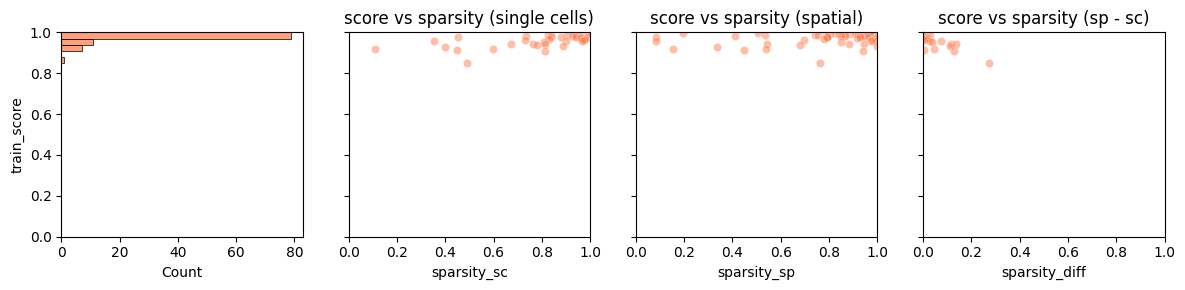

In [21]:
# How well do the counts of the mapped cell correspond with the measured counts in the spatial data (cosine similarity)
# Done for each training gene
tg.plot_training_scores(ad_map, bins=5, alpha=.5)

In [22]:
ad_map.uns['train_genes_df']

,train_score,sparsity_sc,sparsity_sp,sparsity_diff
spn,0.999884,0.999089,0.969897,-0.029193
mmp12,0.999735,0.998446,0.792216,-0.206230
cd3e,0.999732,0.998982,0.975508,-0.023474
chil3,0.999726,0.999786,0.990470,-0.009315
siglech,0.999583,0.999518,0.990381,-0.009137
...,...,...,...,...
slc40a1,0.920513,0.598468,0.539010,-0.059458
ghr,0.919734,0.107200,0.153634,0.046434
cyp2e1,0.915273,0.447177,0.449412,0.002235
nrxn1,0.909567,0.812600,0.942287,0.129687


In [23]:
# Predicted spatial expression of all genes based on mapped single cell data  
ad_ge = tg.project_genes(adata_map=ad_map, adata_sc=ad_sc)
ad_ge 

AnnData object with n_obs × n_vars = 11228 × 24212
    obs: 'region', 'instance', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_2_genes', 'pct_counts_in_top_5_genes', 'n_counts', 'shapeSize', 'uniform_density', 'rna_count_based_density'
    var: 'n_cells', 'sparsity', 'is_training'
    uns: 'annot_colors', 'training_genes', 'overlap_genes'

In [24]:
ad_ge.to_df().head()

,xkr4,gm1992,gm37381,rp1,sox17,mrpl15,lypla1,gm37988,tcea1,rgs20,...,ac132444.1,ac132444.5,csprs,ac132444.6,ac125149.3,ac168977.2,ac168977.1,ac149090.1,caaa01118383.1,caaa01147332.1
cells,,,,,,,,,,,,,,,,,,,,,
64,0.153502,0.000098,0.000032,0.000419,0.003352,0.542748,0.000142,0.119889,1.011445,0.216788,...,0.000008,0.000067,0.000513,2.245051e-07,0.000684,0.000020,0.000034,8.831010,0.281784,0.000056
66,1.978015,0.017445,0.000012,0.000389,0.004983,0.283184,0.000050,0.539815,0.365753,0.230715,...,0.000013,0.000027,0.000376,2.110284e-07,0.000521,0.002075,0.000028,4.409304,0.552076,0.001388
67,1.993787,0.001820,0.000008,0.000273,0.000759,0.004632,0.000032,0.002901,0.047030,0.001408,...,0.000007,0.000017,0.001062,1.668608e-07,0.000133,0.000012,0.000008,0.296623,0.007452,0.000044
68,0.470121,0.000846,0.000017,0.351335,0.002888,0.543738,0.000097,0.379348,0.160479,0.001149,...,0.000009,0.000136,0.001452,6.090368e-07,0.000376,0.000019,0.000207,3.401701,0.087590,0.000166
69,0.119429,0.000349,0.003553,0.000431,0.005256,0.783665,0.000121,0.012330,0.327254,0.001338,...,0.000010,0.000053,0.000637,2.509259e-06,0.000339,0.000017,0.000035,3.850030,0.976616,0.000092


In [25]:
genes = ['spn','chil3','mmp12','cxcl12'] # some training genes
# tg.plot_genes_sc(genes, adata_measured=ad_sp, adata_predicted=ad_ge, perc=0.02)
# plot fails?

In [26]:
# Leave-one-out cross-validation strategy (maybe not so interesting because we have so few genes)
# Should be run on the gpu
cv_dict, ad_ge_cv, test_gene_df = tg.cross_val(
                                     ad_sc,
                                     ad_sp,
                                     # cluster_label = 'annot', (for 'clusters' mode)
                                     mode='cells',
                                     device='cuda:0',
                                     cv_mode='loo', # also 10fold is possible
                                     return_gene_pred = True,
                                     density_prior = 'uniform',
                                     verbose = True, # print training details
                                    )

  0%|          | 0/98 [00:00<?, ?it/s]


RuntimeError: cuda runtime error (100) : no CUDA-capable device is detected at /tmp/pip-req-build-8yht7tdu/aten/src/THC/THCGeneral.cpp:50

In [27]:
### Same but with mode = clusters

In [28]:
ad_map_cl = tg.map_cells_to_space(ad_sc,ad_sp,
    mode="clusters",
    density_prior='uniform', # spatial voxels are at single cell resolution --> must be set to 'uniform'
    num_epochs=500,
    device='cpu',
    cluster_label='annotation')

Score: 0.158, KL reg: 0.185
Score: 0.549, KL reg: 0.006
Score: 0.550, KL reg: 0.006
Score: 0.550, KL reg: 0.006
Score: 0.551, KL reg: 0.006


In [29]:
ad_map_cl.to_df()

cells,64,66,67,68,69,71,72,73,74,77,...,28693,28743,28756,28866,28881,28929,28944,28992,29115,29130
0,1.356039e-04,3.313010e-07,5.436812e-07,6.419752e-05,9.435561e-05,1.087127e-04,1.257618e-04,1.101041e-04,1.276532e-04,1.094141e-04,...,1.360450e-04,1.296529e-04,4.480682e-07,1.582626e-04,1.359951e-04,1.058732e-04,1.610329e-04,0.000111,1.303976e-06,0.000047
1,1.653159e-05,1.030188e-06,1.801070e-07,7.872163e-07,8.647412e-05,4.515283e-05,4.970869e-05,8.113521e-05,6.102305e-05,7.174613e-05,...,5.632507e-05,3.294832e-05,4.218980e-05,4.062665e-07,3.639425e-05,8.288370e-05,2.663766e-06,0.000050,7.247168e-04,0.000004
2,2.736739e-07,3.452357e-07,1.619911e-07,2.352316e-05,5.540127e-05,2.688127e-05,8.626504e-07,2.874728e-05,3.087232e-06,3.499126e-05,...,1.289894e-07,8.670866e-06,8.916727e-04,6.957134e-07,3.714238e-06,3.670695e-05,1.750507e-06,0.000034,9.918181e-07,0.000072
3,3.336136e-05,2.443848e-06,5.553447e-07,2.149648e-06,3.839429e-05,2.223418e-05,3.446151e-05,2.288147e-05,3.410784e-06,2.694486e-05,...,8.871080e-05,8.116274e-06,1.118292e-05,3.057839e-06,1.338328e-06,2.879950e-05,9.423347e-07,0.000025,3.647629e-07,0.000001
4,1.379607e-06,1.051378e-03,8.567648e-08,4.158000e-07,7.753387e-07,1.635742e-07,4.039484e-07,5.182508e-07,1.380458e-07,1.096022e-07,...,2.519969e-07,1.016248e-06,8.706249e-05,7.774466e-07,2.125312e-06,1.941406e-06,1.951832e-07,0.000097,6.784979e-06,0.001683
5,5.208176e-05,6.050423e-07,1.165600e-06,1.012915e-05,3.763072e-05,6.571701e-05,3.184336e-05,2.361564e-05,2.994273e-06,2.777404e-05,...,4.948913e-07,1.481910e-05,6.773981e-07,8.542210e-07,4.688570e-05,2.936357e-05,6.712003e-07,0.000018,6.774860e-07,0.000132
6,1.413925e-05,5.788227e-04,6.474839e-04,3.886731e-04,9.260792e-06,2.488243e-06,1.765956e-06,1.988117e-06,8.267742e-06,2.627681e-06,...,5.280149e-05,4.100360e-06,1.283339e-06,1.654344e-06,1.846602e-06,1.111338e-06,2.435817e-06,0.000005,8.941820e-07,0.000002
7,8.155126e-05,2.267664e-03,3.464851e-03,1.113694e-03,1.601177e-04,1.311008e-04,8.892280e-05,1.229601e-04,8.005556e-05,1.323345e-04,...,5.272427e-07,1.027026e-04,2.323656e-06,1.788405e-06,6.313827e-05,1.354569e-04,6.977707e-07,0.000129,6.892364e-07,0.000010
8,8.312109e-06,4.294048e-08,7.644278e-07,7.042091e-07,5.117751e-05,1.736819e-04,8.243118e-07,1.997419e-06,4.046081e-07,3.404521e-06,...,4.001967e-06,1.957100e-07,4.880781e-07,5.497976e-07,3.482383e-07,2.131357e-06,5.926626e-07,0.000006,2.103095e-07,0.000003
9,4.490959e-07,8.050940e-08,3.479604e-07,9.162466e-07,1.740565e-06,3.090895e-07,9.265079e-07,4.662810e-07,6.621908e-07,4.788851e-07,...,8.971804e-07,6.936947e-07,4.057499e-07,6.756738e-07,9.580073e-07,3.301761e-07,2.356794e-07,0.000002,3.814016e-07,0.000001


In [30]:
ad_map_cl.obs['annotation']

0      Hepa
1      Stel
2      LSEC
3       Oth
4      Kupf
5      Endo
6      Fibr
7      Meso
8      Chol
9    B cell
Name: annotation, dtype: category
Categories (10, object): ['B cell', 'Chol', 'Endo', 'Hepa', ..., 'Meso', 'Oth', 'Fibr', 'Stel']

In [31]:
ad_sp.obs['tangram_cl'] = ad_map_cl.to_df().idxmax(axis=0).to_list()
ad_sp.obs['tangram_cl'].replace(ad_map_cl.obs['annotation'].index.to_list(),ad_map_cl.obs['annotation'].to_list(), inplace=True)

In [32]:
# get max value of each row
max_scores = ad_map_cl.to_df().max(axis=0)
# get second highest value of each row
second_scores = ad_map_cl.to_df().apply(lambda x: x.nlargest(2).values[-1], axis=0)
cleanliness = (max_scores - second_scores) / ((abs(max_scores) + abs(second_scores)) / 2)
ad_sp.obs['tangram_cleanliness_cl'] = cleanliness

In [33]:
ad_sp.obs

,region,instance,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_2_genes,pct_counts_in_top_5_genes,n_counts,shapeSize,uniform_density,rna_count_based_density,tangram,tangram_cleanliness,tangram_cl,tangram_cleanliness_cl
cells,,,,,,,,,,,,,,,,
64,1,1,12,2.564949,150,5.017280,74.666667,92.000000,150,2545.0,0.000089,0.000106,Hepa,1.788765,Hepa,0.497825
66,1,1,16,2.833213,38,3.663562,36.842105,68.421053,38,1257.0,0.000089,0.000081,Kupf,0.657668,Meso,0.732914
67,1,1,15,2.772589,50,3.931826,52.000000,76.000000,50,3057.0,0.000089,0.000045,Meso,1.056517,Meso,1.370203
68,1,1,8,2.197225,84,4.442651,80.952381,95.238095,84,2071.0,0.000089,0.000076,Meso,0.178839,Meso,0.965171
69,1,1,6,1.945910,52,3.970292,67.307692,98.076923,52,1637.0,0.000089,0.000071,Hepa,1.850960,Meso,0.516849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28929,1,1,8,2.197225,108,4.691348,87.037037,97.222222,108,2285.0,0.000089,0.000081,Hepa,0.416688,Meso,0.245172
28944,1,1,11,2.484907,155,5.049856,71.612903,92.258065,155,1942.0,0.000089,0.000140,Hepa,1.917389,Hepa,1.934910
28992,1,1,10,2.397895,132,4.890349,71.969697,94.696970,132,3627.0,0.000089,0.000078,Hepa,0.696153,Meso,0.151974


In [34]:
ad_sp.write_h5ad('/home/wout/Documents/Thesis_lokaal/Mouse_Liver_Resolve_Data/anndataNucA11_tangram.h5ad')